**Data:** 

The FACS dataset (Tasic et al. 2018) is split into two subsets (A and B) with roughly 10,000 samples each, where samples of four cell types were allowed to be in only of the two subsets. From among the cell types shared across A and B, we considered `1/3 of the cells ’paired’` based on (i) their cell type label, (ii) similarity of peptidergic gene expression, and (iii) distance in a representation obtained for the complete FACS dataset by a single autoencoder.

**Results:**
 - types unique to subset A (cyan and grey-blue) appear in $z_A$ in positions that are not occupied by other cell types in $z_B$ 
 - types unique to subset B (`dark blue` and `yellow-brown`) appear in $z_B$ in positions that are not occupied by other cell types in $z_A$  
 - a type present in both subsets for which no cells were marked as paired occupied similar positions in $z_A$ and $z_B$ (`pink`). 

In [1]:
import scipy.io as sio
import scipy

D = sio.loadmat('./data/raw/split-facs-data.mat',squeeze_me=True);
R = sio.loadmat('./data/results/split-facs-5kgenes/SF_ng_5000_cs_1-0_pd_0-5_bs_500_np_200_se_20_ne_5000_cv_0_ri_0_ws_True_dn_dat2_4k-summary.mat',squeeze_me=True)

z0 = np.concatenate([R['z_train_0'],R['z_val_0']],axis=0);
sort_ind = np.argsort(np.concatenate([R['train_ind_T'],R['val_ind_T']],axis=0))
train_0 = sort_ind[:R['train_ind_T'].size]
test_0 = sort_ind[R['train_ind_T'].size:]
z0 = z0[sort_ind,:];
inT=np.isin(D['T_cluster'],D['clusters_T_only']);
inTE=np.isin(D['T_cluster'],D['clusters_TE_unpaired']);

z1 = np.concatenate([R['z_train_1'],R['z_val_1']],axis=0);
sort_ind = np.argsort(np.concatenate([R['train_ind_E'],R['val_ind_E']],axis=0))
train_1 = sort_ind[:R['train_ind_E'].size]
test_1 = sort_ind[R['train_ind_E'].size:]
z1 = z1[sort_ind,:];
inE=np.isin(D['E_cluster'],D['clusters_E_only']);
inET=np.isin(D['E_cluster'],D['clusters_TE_unpaired']);

Representations of both datasets.

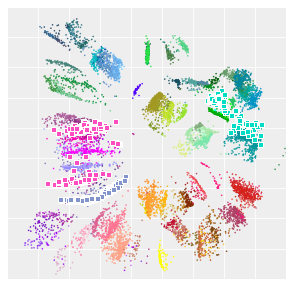

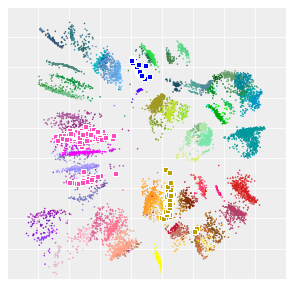

In [2]:
import seaborn as sns
sns.set_style("darkgrid")

def ax_style(ax):
    ax.set_facecolor('#EEEEEE')
    xlims = [-2.5,1.9]
    ylims = [-2.2,2.2]
    ax.set_xlim(xlims[0],xlims[1])
    ax.set_ylim(ylims[0],ylims[1])
    ax.set_xticks(np.linspace(xlims[0],xlims[1],num=10))
    ax.set_yticks(np.linspace(ylims[0],ylims[1],num=10))
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    return

#Plot subset A
fig_5A_l = plt.figure(figsize=(5,5))

plt.scatter(z0[~inT,0],z0[~inT,1],s=0.3,edgecolor=None,facecolor=D['T_cluster_color'][~inT],alpha=1)
plt.scatter(z0[inT,0],z0[inT,1],s=25,marker='s',edgecolor='#FFFFFF',facecolor=D['T_cluster_color'][inT])
plt.scatter(z0[inTE,0],z0[inTE,1],s=25,marker='s',edgecolor='#FFFFFF',facecolor=D['T_cluster_color'][inTE])
ax = plt.gca()
ax_style(ax)

fig_5A_l.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig5A-l.pdf',
                dpi=300, format='pdf', bbox_inches='tight')

#Plot subset B
fig_5A_r = plt.figure(figsize=(5,5))
plt.scatter(z1[~inE,0],z1[~inE,1],s=0.3,edgecolor=None,facecolor=D['E_cluster_color'][~inE],alpha=1)
plt.scatter(z1[inE,0],z1[inE,1],s=25,marker='s',edgecolor='#FFFFFF',facecolor=D['E_cluster_color'][inE])
plt.scatter(z1[inET,0],z1[inET,1],s=25,marker='s',edgecolor='#FFFFFF',facecolor=D['E_cluster_color'][inET])
ax = plt.gca()
ax_style(ax) 

fig_5A_r.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig5A-r.pdf',
                dpi=300, format='pdf', bbox_inches='tight')
plt.show()

Quantifying the degree to which the unique types in *A* can be distinguished:

 - Calculate distance with the closest K nearest neighbors in B for each point belonging to the unique type in A
 - Calculate distance distribution of the nearest neighbors for all points in B

If these distributions are very different it indicates that the unique type is discoverable as an island by clustering on the representations.

In [3]:
from sklearn.neighbors import NearestNeighbors

bined = np.arange(0,0.2,0.005)
prop_all_others = {'color':'#999999','edgecolor':'gray','alpha':1,'density':True}
def manip_axes(ax):
    ax.set_xticks(np.arange(0,0.2,0.02))
    ax.xaxis.set_ticklabels([0,'','','',0.08,'','','',0.16])
    ax.set_xlim(-0.005,0.190)
    
    ax.set_ylim(0.00,55)
    ax.yaxis.set_ticklabels([0,'','','',40])
    ax.set_yticks(np.arange(0,60,10))
    
    for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(22)
    
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(14)
    return ax

Cells for types unique to *A*:

p value: 1.664776901673722e-14
p value: 1.9467495393499235e-09


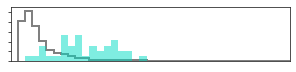

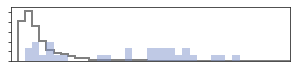

In [4]:
zT = R['z_val_0']
cT = D['T_cluster_color'][R['val_ind_T']]
clT = D['T_cluster'][R['val_ind_T']]

zE = R['z_train_1']
cE = D['E_cluster_color'][R['train_ind_E']]
clE = D['E_cluster'][R['train_ind_E']]

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(zE)
dist, indices = nbrs.kneighbors(zT)   

d_remaining = dist[np.isin(clT,np.setdiff1d(clT,D['clusters_T_only'])),0]

sns.set_style('ticks')
for cl in D['clusters_T_only']:
    d_this_cl = dist[clT==cl,0]
    col = np.unique(cT[clT==cl])[0]
    plt.figure(figsize=(5,1))
    plt.hist(d_remaining, bins=bined,**prop_all_others,histtype='step',lw=2)
    plt.hist(d_this_cl, bins=bined,facecolor=col,alpha=0.5,lw=0,edgecolor=None,density=True,histtype='stepfilled')
    ax=plt.gca()
    ax = manip_axes(ax)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_xticks([])
    plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig5B_hist_'+cl+'.pdf', 
           dpi = 300,format='pdf', bbox_inches='tight')
    [ks_stat,p_val] = scipy.stats.ks_2samp(d_remaining,d_this_cl)
    print('p value: '+str(p_val))

Cells for types unique to *B*:

p value: 1.4432899320127035e-15
p value: 3.5522847996460882e-09


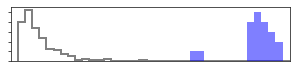

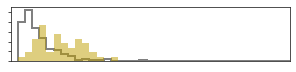

In [5]:
zE = R['z_val_1']
cE = D['E_cluster_color'][R['val_ind_E']]
clE = D['E_cluster'][R['val_ind_E']]

zT = R['z_train_0']
cT = D['T_cluster_color'][R['train_ind_T']]
clT = D['T_cluster'][R['train_ind_T']]

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(zT)
dist, indices = nbrs.kneighbors(zE)   

d_remaining = dist[np.isin(clE,np.setdiff1d(clE,D['clusters_E_only'])),0]
for cl in D['clusters_E_only']:
    d_this_cl = dist[clE==cl,0]
    col = np.unique(cE[clE==cl])[0]
    plt.figure(figsize=(5,1))
    plt.hist(d_remaining, bins=bined,**prop_all_others,histtype='step',lw=2)
    plt.hist(d_this_cl, bins=bined,facecolor=col,alpha=0.5,lw=0,edgecolor=None,density=True,histtype='stepfilled')

    ax=plt.gca()
    manip_axes(ax)
    ax.yaxis.set_ticklabels([])
    ax.set_xticks([])
    plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig5B_hist_'+cl+'.pdf', 
           dpi = 300,format='pdf', bbox_inches='tight')
    [ks_stat,p_val] = scipy.stats.ks_2samp(d_remaining,d_this_cl)
    print('p value: '+str(p_val))

Cells for types in both *A* and *B* but never shown to the entwork as paired.

p value: 0.8809951729820139


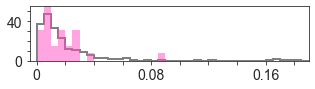

In [6]:
zE = R['z_val_1']
cE = D['E_cluster_color'][R['val_ind_E']]
clE = D['E_cluster'][R['val_ind_E']]

zT = R['z_train_0']
cT = D['T_cluster_color'][R['train_ind_T']]
clT = D['T_cluster'][R['train_ind_T']]

nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(zT)
dist, indices = nbrs.kneighbors(zE)

d_remaining = dist[np.isin(clE,np.setdiff1d(clE,[D['clusters_TE_unpaired']])),0]
for cl in [D['clusters_TE_unpaired']]:
    d_this_cl = dist[clE==cl,0]
    col = np.unique(cE[clE==cl])[0]
    plt.figure(figsize=(5,1))
    plt.hist(d_remaining, bins=bined,**prop_all_others,histtype='step',lw=2)
    plt.hist(d_this_cl, bins=bined,facecolor=col,alpha=0.5,lw=0,edgecolor=None,density=True,histtype='stepfilled')
    
    ax=plt.gca()
    manip_axes(ax) 
    plt.savefig('/Users/fruity/Dropbox/AllenInstitute/CellTypes/doc/NeurIPS 2019/camready/Fig5B_hist_'+cl+'.pdf', 
            dpi=300,format='pdf', bbox_inches='tight')
    [ks_stat,p_val] = scipy.stats.ks_2samp(d_remaining,d_this_cl)
    print('p value: '+str(p_val))